In [1]:
import matplotlib.pyplot as plt
import numpy as np

import healpy as hp

import src.observing as OBS
import src.sky_models as SM
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.beam_functions as BF
import src.map_making as MM
from src.blockmat import BlockMatrix, BlockVector

RS = SH.RealSphericalHarmonics()

In [2]:
basemap_err = 10
err_type='idx'

nside = 32
lmax  = 32
lmod  = 5
Nlmax = RS.get_size(lmax)
Nlmod = RS.get_size(lmod)

# Observation and binning params.
Ntau  = None
Nt    = 24
times = np.linspace(0, 24, Nt, endpoint=False)
nuarr = np.linspace(50,100,51)
lats = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])

# Cosmological parameters.
cm21_params = OBS.cm21_params

# Foreground correction reference frequency.
err_ref = 70

# Generate foreground and 21-cm signal alm
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_params)
fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, 
    use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err, ref_freq=err_ref), 
    err_type=err_type, seed=101, meancorr=False)
fid_alm = fg_alm + cm21_alm

# Generate observation matrix for the modelling and for the observations.
narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)
mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)
mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
mat_A_mod = mat_A[:,:Nlmod]
mat_A_unmod = mat_A[:,Nlmod:]

# Perform fiducial observations
d = mat_A @ fid_alm
dnoisy, noise_covar = SM.add_noise(d, 1, Ntau=len(times), t_int=200, seed=456)

# Generate a missing-modes correction analytically.
alm_mean, alm_cov = SM.gsma_corr(lmod, lmax, nside, nuarr, basemap_err, ref_freq=err_ref)
data_corr = mat_A_unmod @ alm_mean
covar_corr = mat_A_unmod @ (alm_cov/1) @ mat_A_unmod.T

# Reconstruct the max likelihood estimate of the alm
mat_W, cov = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=noise_covar+covar_corr, cov=True, cond=True)
alm_error = np.sqrt(cov.diag)
rec_alm = mat_W @ (dnoisy - data_corr)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<10>
1/condition #: 4.234905237413075e-09


In [3]:
rec = rec_alm[0]
tot = BlockVector(fid_alm, nblock=len(nuarr))[0]
fgs = BlockVector(fg_alm, nblock=len(nuarr))[0]
c21 = BlockVector(cm21_alm, nblock=len(nuarr))[0]
err = BlockVector(alm_error, nblock=len(nuarr))[0]

<ErrorbarContainer object of 3 artists>

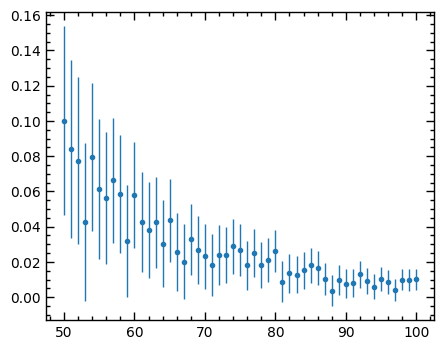

In [4]:
plt.errorbar(nuarr, rec-tot, err, fmt='.')

In [55]:
basemap_err = 10
err_type='idx'

nside = 32
lmax  = 5
lmod  = 5
Nlmax = RS.get_size(lmax)
Nlmod = RS.get_size(lmod)

# Observation and binning params.
Ntau  = None
Nt    = 24
times = np.linspace(0, 24, Nt, endpoint=False)
nuarr = np.linspace(50,100,51)
lats = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])

# Cosmological parameters.
cm21_params = OBS.cm21_params

# Foreground correction reference frequency.
err_ref = 70

# Generate foreground and 21-cm signal alm
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_params)
fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, 
    use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err, ref_freq=err_ref), 
    err_type=err_type, seed=100, meancorr=False)
fid_alm = fg_alm + cm21_alm

# Generate observation matrix for the modelling and for the observations.
narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)
mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)
mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))

# Perform fiducial observations
d = mat_A @ fid_alm
dnoisy, noise_covar = SM.add_noise(d, 1, Ntau=len(times), t_int=200, seed=456)

# Reconstruct the max likelihood estimate of the alm
mat_W, cov = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=noise_covar, cov=True, cond=True)
alm_error = np.sqrt(cov.diag)
rec_alm = mat_W @ (dnoisy)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 21
1/condition #: 6.898122468659319e-08


<ErrorbarContainer object of 3 artists>

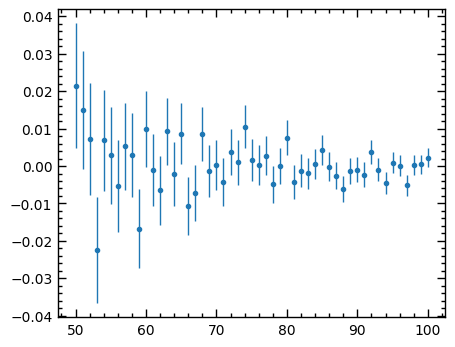

In [56]:
rec = rec_alm[0]
tot = BlockVector(fid_alm, nblock=len(nuarr))[0]
fgs = BlockVector(fg_alm, nblock=len(nuarr))[0]
c21 = BlockVector(cm21_alm, nblock=len(nuarr))[0]
err = BlockVector(alm_error, nblock=len(nuarr))[0]
plt.errorbar(nuarr, rec-tot, err, fmt='.')